In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import scvelo as scv
#from dataloaders import *

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import scanpy as sc


class CustomDataset(Dataset):
    def __init__(self, adata):
        unspliced = torch.tensor(adata.layers["unspliced"].toarray(), dtype=torch.float32)
        spliced = torch.tensor(adata.layers["spliced"].toarray(), dtype=torch.float32)
        self.x = torch.cat([unspliced, spliced], dim=1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], idx
    

def setup_dataloaders(adata, batch_size, train_size=0.8, split_data=True):
    custom_dataset = CustomDataset(adata)
    if split_data:
        num_samples = len(custom_dataset)
        indices = np.random.permutation(num_samples)
        split = int(train_size * num_samples)
        train_indices, test_indices = indices[:split], indices[split:]
        adata.uns["train_indices"] = train_indices
        adata.uns["test_indices"] = test_indices

        print(f"number of training observations: {len(train_indices)}")
        print(f"number of test observations: {len(test_indices)}")
        
        train_subset = Subset(custom_dataset, train_indices)
        test_subset = Subset(custom_dataset, test_indices)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    else:
        train_subset = custom_dataset
        test_loader = None

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    full_data_loader = DataLoader(custom_dataset, batch_size=256, shuffle=False)  # Simplified DataLoader

    return train_loader, test_loader, full_data_loader

# Encoder-only Model Definition (no decoder)
class GeodesicEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims):
        super(GeodesicEncoder, self).__init__()
        
        # Encoder layers
        encoder_layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            in_dim = h_dim
        encoder_layers.append(nn.Linear(in_dim, latent_dim))  # Latent space output
        self.encoder = nn.Sequential(*encoder_layers)
        
    def forward(self, x):
        z = self.encoder(x)  # Only return the latent space representation
        return z


def geodesic_distance_loss(latent, geodesic_distances, batch_indices, k=5):
    # Compute pairwise distances in latent space
    pairwise_distances = torch.cdist(latent, latent, p=2)
    pairwise_distances = pairwise_distances / pairwise_distances.max()  # Normalize
    
    # Get the relevant geodesic distances for the batch
    batch_geodesic_distances = geodesic_distances[batch_indices, :][:, batch_indices]
    batch_geodesic_distances = batch_geodesic_distances / batch_geodesic_distances.max()  # Normalize
    
    # Create the k-nearest neighbor mask
    geodesic_mask = torch.zeros_like(batch_geodesic_distances)
    for i in range(batch_geodesic_distances.size(0)):
        nearest_indices = torch.topk(batch_geodesic_distances[i], k=k, largest=False)[1]
        geodesic_mask[i, nearest_indices] = 1.0
    
    # Geodesic distance preservation loss
    geodesic_loss = geodesic_mask * (pairwise_distances - batch_geodesic_distances) ** 2
    geodesic_loss = geodesic_loss.sum()
    
    # Repulsion loss to prevent collapse
    repulsion_loss = torch.sum(torch.exp(-pairwise_distances)) / (pairwise_distances.size(0) ** 2)
    
    return geodesic_loss + 0.01 * repulsion_loss



# Training function with only geodesic distance preservation
def train_geodesic_encoder(model, data_loader, geodesic_distances, epochs=100, lr=1e-3, lambda_geo=1.0):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_data, batch_indices in data_loader:
            optimizer.zero_grad()

            # Forward pass through the encoder to get latent representations
            latent = model(batch_data)
            
            # Compute geodesic distance loss
            geodesic_loss = geodesic_distance_loss(latent, geodesic_distances, batch_indices)
            
            # Total loss (only geodesic loss in this case)
            loss = lambda_geo * geodesic_loss
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Lambda Geo Loss: {lambda_geo * geodesic_loss.item():.4f}")



# Save Latent Variables in adata.obsm["z"]
def save_latent_variables(model, data_loader, adata):
    model.eval()  # Set model to evaluation mode
    all_latents = []
    
    with torch.no_grad():
        for batch_data, _ in data_loader:
            latent = model(batch_data)
            all_latents.append(latent)
    
    # Concatenate all latent variables and save to adata.obsm["z"]
    all_latents = torch.cat(all_latents, dim=0).numpy()  # Convert to NumPy array
    adata.obsm["z"] = all_latents
    print(f"Latent variables saved to adata.obsm['z'] with shape: {adata.obsm['z'].shape}")




# Example Usage
if __name__ == "__main__":
    # Load AnnData (Example)
    adata = scv.datasets.pancreas()
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata)
    adata.raw = adata  # Using raw data as input for simplicity
    
    # Setup DataLoader
    batch_size = 64
    train_loader, test_loader, full_data_loader = setup_dataloaders(adata, batch_size)
    
    # Compute geodesic distances for training
    data = np.concatenate([adata.layers["unspliced"].toarray(), adata.layers["spliced"].toarray()], axis=1)
    k = 5
    knn_graph = kneighbors_graph(data, n_neighbors=k, mode="distance", include_self=False)
    geodesic_distances = np.asarray(knn_graph.toarray())
    
    # Normalize geodesic distances
    geodesic_distances[geodesic_distances == 0] = np.inf  # Set disconnected pairs to infinity
    geodesic_distances = np.nan_to_num(1 / geodesic_distances)  # Invert distances
    geodesic_distances_tensor = torch.tensor(geodesic_distances, dtype=torch.float32)
    
    # Define Model
    input_dim = data.shape[1]
    latent_dim = 64
    hidden_dims = [1024, 512, 256]
    model = GeodesicEncoder(input_dim, latent_dim, hidden_dims)
    
    # Train the model
    train_geodesic_encoder(
        model,
        full_data_loader,
        geodesic_distances_tensor,
        epochs=100,
        lr=1e-1,
        lambda_geo=1.0
    )

    save_latent_variables(model, full_data_loader, adata)


Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
number of training observations: 2956
number of test observations: 740
Epoch 1/100, Loss: 399.0136, Lambda Geo Loss: 51.8021
Epoch 2/100, Loss: 194.8210, Lambda Geo Loss: 19.8951
Epoch 3/100, Loss: 118.9096, Lambda Geo Loss: 5.7033
Epoch 4/100, Loss: 131.0778, Lambda Geo Loss: 8.7355
Epoch 5/100, Loss: 101.9907, Lambda Geo Loss: 4.5006
Epoch 6/100, Loss: 84.3331, Lambda Geo Loss: 4.4126
Epoch 7/100, Loss: 76.6304, Lambda Geo Loss: 4.0113
Epoch 8/100, Loss: 74.8586, Lambda Geo Loss: 4.2345
Epoch 9/100, Loss: 73.5078, Lambda Geo Loss: 3.7845
Epoch 10/100, Loss: 68.5017, Lambda Geo Loss: 3.9467
Epoch 11/100, Loss: 67.1613, Lambda Geo Loss: 3.8722
Epoch 12/100, Loss: 65.9662, Lambda Geo Loss: 3.6954
Epoch 13/100, Loss: 60.8377, Lambda Geo

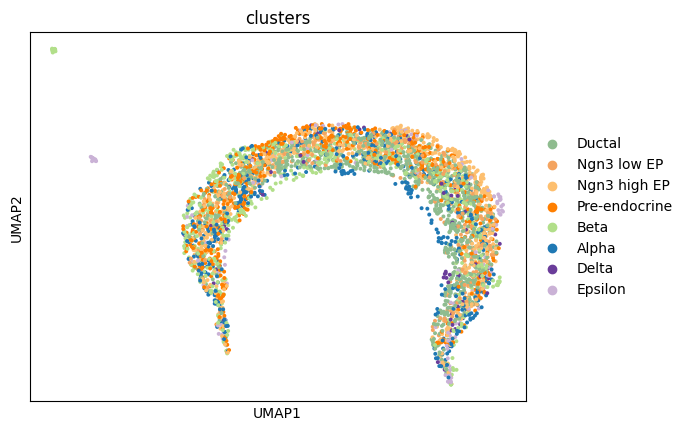

In [2]:
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata)
sc.pl.umap(adata, color="clusters")